In [1]:
import os

# token from your image here
os.environ['KAGGLE_API_TOKEN'] = 'KGAT_268425d7a48137ae7147d44963ea0db4'

# User provided Kaggle username
KAGGLE_USERNAME = 'keshavnarsale'

# Create the .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Create kaggle.json file
kaggle_json_content = f'{{"username":"{KAGGLE_USERNAME}","key":"{os.environ["KAGGLE_API_TOKEN"]}"}}'
with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
    f.write(kaggle_json_content)

# Set permissions for kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Now you can download the dataset immediately
!kaggle datasets download -d khanfashee/nih-chest-x-ray-14-224x224-resized
!unzip -q nih-chest-x-ray-14-224x224-resized.zip

Dataset URL: https://www.kaggle.com/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized
License(s): CC0-1.0
100% 2.30G/2.30G [00:16<00:00, 249MB/s]
100% 2.30G/2.30G [00:16<00:00, 147MB/s]


Import Libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast

print("✓ All libraries imported successfully")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

✓ All libraries imported successfully
PyTorch Version: 2.9.0+cu126
CUDA Available: True


Configuration and Setup

In [3]:
# Paths and parameters
IMAGE_DIR = '/content/images-224/images-224'
CSV_FILE = 'Data_Entry_2017.csv'

# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
EPOCHS = 15
PATIENCE = 5

# Disease labels
LABELS = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule',
          'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema',
          'Fibrosis', 'Pleural_Thickening', 'Hernia']

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_mixed_precision = torch.cuda.is_available()

print(f"\n{'='*60}")
print(f"Configuration:")
print(f"  Device: {device}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Mixed Precision: {use_mixed_precision}")
print(f"{'='*60}\n")


Configuration:
  Device: cuda
  Batch Size: 32
  Learning Rate: 0.0001
  Epochs: 15
  Mixed Precision: True



Load and Prepare Data

In [4]:
# Load dataset
df = pd.read_csv(CSV_FILE)

# Create binary columns for each disease
for label in LABELS:
    df[label] = df['Finding Labels'].map(lambda x: 1 if label in x else 0)

# Patient-wise split (prevents data leakage)
unique_patients = df['Patient ID'].unique()
train_p, val_p = train_test_split(unique_patients, test_size=0.2, random_state=42)
train_df = df[df['Patient ID'].isin(train_p)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_p)].reset_index(drop=True)

print(f"Dataset loaded:")
print(f"  Training samples: {len(train_df):,}")
print(f"  Validation samples: {len(val_df):,}")
print(f"  Total images: {len(df):,}")
print(f"\nClass distribution (training set):")
print(train_df[LABELS].sum().sort_values(ascending=False))

Dataset loaded:
  Training samples: 89,826
  Validation samples: 22,294
  Total images: 112,120

Class distribution (training set):
Infiltration          15776
Effusion              10757
Atelectasis            9332
Nodule                 5043
Mass                   4677
Pneumothorax           4279
Consolidation          3716
Pleural_Thickening     2725
Cardiomegaly           2154
Emphysema              1985
Edema                  1849
Fibrosis               1322
Pneumonia              1073
Hernia                  179
dtype: int64


Calculate Class Weights

In [5]:
def get_weights(dataframe, smoothing=5.0):
    """Calculate class weights with less aggressive smoothing"""
    pos_counts = dataframe[LABELS].sum().values + smoothing
    neg_counts = len(dataframe) - dataframe[LABELS].sum().values + smoothing
    weights = torch.tensor(neg_counts / pos_counts, dtype=torch.float32)
    weights = torch.clamp(weights, min=1.0, max=30.0)
    return weights

pos_weights = get_weights(train_df).to(device)

print("\nClass weights calculated (more balanced):")
for label, weight in zip(LABELS, pos_weights.cpu().numpy()):
    print(f"  {label:<20} {weight:.2f}")


Class weights calculated (more balanced):
  Atelectasis          8.62
  Cardiomegaly         30.00
  Effusion             7.35
  Infiltration         4.69
  Mass                 18.19
  Nodule               16.80
  Pneumonia            30.00
  Pneumothorax         19.97
  Consolidation        23.14
  Edema                30.00
  Emphysema            30.00
  Fibrosis             30.00
  Pleural_Thickening   30.00
  Hernia               30.00


Data Augmentation and Transforms

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("✓ Data augmentation configured")

✓ Data augmentation configured


Dataset and DataLoader

In [7]:
class NIHDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            img_path = os.path.join(IMAGE_DIR, self.df.iloc[idx, 0])
            image = Image.open(img_path).convert('RGB')
            label = torch.tensor(self.df.iloc[idx][LABELS].values.astype(float), dtype=torch.float32)

            if self.transform:
                image = self.transform(image)

            return image, label
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return torch.zeros((3, 224, 224)), torch.zeros(len(LABELS))

# Create data loaders
train_loader = DataLoader(
    NIHDataset(train_df, train_transform),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    NIHDataset(val_df, val_transform),
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=True
)

print(f" Data loaders created")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")


 Data loaders created
  Training batches: 2808
  Validation batches: 697


Model Architecture (EfficientNet-B4 - BEST PERFORMANCE)

In [8]:
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

# Load pretrained EfficientNet-B4
model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)

# Modify classifier for multi-label classification
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(LABELS))
)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: EfficientNet-B4")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:00<00:00, 137MB/s]


Model: EfficientNet-B4
  Total parameters: 18,473,814
  Trainable parameters: 18,473,814


Loss Function and Optimizer

In [9]:
# Use STANDARD BCE Loss instead of Label Smoothing for first few epochs
# This trains faster initially

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
print("✓ Using standard BCE Loss (no label smoothing)")

# Option 2: If you want to keep label smoothing, reduce it:
# class LabelSmoothingBCELoss(nn.Module):
#     def __init__(self, smoothing=0.05, pos_weight=None):  # Reduced from 0.1
#         super().__init__()
#         self.smoothing = smoothing
#         self.pos_weight = pos_weight
#
#     def forward(self, pred, target):
#         target = target * (1 - self.smoothing) + 0.5 * self.smoothing
#         loss = nn.functional.binary_cross_entropy_with_logits(
#             pred, target, pos_weight=self.pos_weight
#         )
#         return loss
#
# criterion = LabelSmoothingBCELoss(smoothing=0.05, pos_weight=pos_weights)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)
scaler = GradScaler()

# SWA setup
from torch.optim.swa_utils import AveragedModel, SWALR
swa_model = AveragedModel(model)
swa_scheduler = SWALR(optimizer, swa_lr=0.00005)
swa_start = 10

✓ Using standard BCE Loss (no label smoothing)


/tmp/ipython-input-2939091874.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Early Stopping

In [10]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

print("Early stopping configured")

Early stopping configured


Training Loop

In [11]:
def run_training():
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    early_stopping = EarlyStopping(patience=PATIENCE)

    print(f"\n{'='*70}")
    print(f"{'TRAINING STARTED':^70}")
    print(f"{'='*70}\n")

    for epoch in range(EPOCHS):
        # TRAINING PHASE
        model.train()
        t_loss = 0

        for batch_idx, (imgs, lbls) in enumerate(train_loader):
            imgs, lbls = imgs.to(device), lbls.to(device)

            optimizer.zero_grad()

            if use_mixed_precision:
                with autocast():
                    outputs = model(imgs)
                    loss = criterion(outputs, lbls)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(imgs)
                loss = criterion(outputs, lbls)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            t_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:
                print(f"  Epoch [{epoch+1:2d}/{EPOCHS}] Batch [{batch_idx+1:4d}/{len(train_loader)}] Loss: {loss.item():.4f}")

        # VALIDATION PHASE
        model.eval()
        v_loss = 0

        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)

                if use_mixed_precision:
                    with autocast():
                        outputs = model(imgs)
                        v_loss += criterion(outputs, lbls).item()
                else:
                    outputs = model(imgs)
                    v_loss += criterion(outputs, lbls).item()

        avg_train = t_loss / len(train_loader)
        avg_val = v_loss / len(val_loader)
        train_losses.append(avg_train)
        val_losses.append(avg_val)

        # Update learning rate
        if epoch >= swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']

        # Print epoch summary
        print(f"\n{'─'*70}")
        print(f"Epoch {epoch+1}/{EPOCHS} Summary:")
        print(f"  Train Loss: {avg_train:.4f}")
        print(f"  Val Loss:   {avg_val:.4f}")
        print(f"  LR:         {current_lr:.6f}")

        # Save best model
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), 'best_chest_model.pth')
            print(f"  ✓ Best model saved! (Val Loss: {avg_val:.4f})")

        # Early stopping
        early_stopping(avg_val)
        if early_stopping.early_stop:
            print(f"\n⚠ Early stopping triggered at epoch {epoch+1}")
            break

        print(f"{'─'*70}\n")

    # Save SWA model
    if EPOCHS >= swa_start:
        print("\nUpdating SWA model batch normalization...")
        torch.optim.swa_utils.update_bn(train_loader, swa_model, device=device)
        torch.save(swa_model.state_dict(), 'swa_chest_model.pth')
        print("✓ SWA model saved!")

    return train_losses, val_losses

# Execute training
history = run_training()

print(f"\n{'='*70}")
print(f"{'TRAINING COMPLETED':^70}")
print(f"{'='*70}\n")



                           TRAINING STARTED                           



/tmp/ipython-input-252855491.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Epoch [ 1/15] Batch [ 100/2808] Loss: 1.1992
  Epoch [ 1/15] Batch [ 200/2808] Loss: 1.1804
  Epoch [ 1/15] Batch [ 300/2808] Loss: 1.3008
  Epoch [ 1/15] Batch [ 400/2808] Loss: 1.2773
  Epoch [ 1/15] Batch [ 500/2808] Loss: 0.7448
  Epoch [ 1/15] Batch [ 600/2808] Loss: 0.8780
  Epoch [ 1/15] Batch [ 700/2808] Loss: 1.0501
  Epoch [ 1/15] Batch [ 800/2808] Loss: 1.2860
  Epoch [ 1/15] Batch [ 900/2808] Loss: 1.6330
  Epoch [ 1/15] Batch [1000/2808] Loss: 1.2050
  Epoch [ 1/15] Batch [1100/2808] Loss: 0.8872
  Epoch [ 1/15] Batch [1200/2808] Loss: 1.0751
  Epoch [ 1/15] Batch [1300/2808] Loss: 0.9276
  Epoch [ 1/15] Batch [1400/2808] Loss: 1.0511
  Epoch [ 1/15] Batch [1500/2808] Loss: 1.1735
  Epoch [ 1/15] Batch [1600/2808] Loss: 0.9448
  Epoch [ 1/15] Batch [1700/2808] Loss: 0.6672
  Epoch [ 1/15] Batch [1800/2808] Loss: 1.1483
  Epoch [ 1/15] Batch [1900/2808] Loss: 0.7713
  Epoch [ 1/15] Batch [2000/2808] Loss: 0.9242
  Epoch [ 1/15] Batch [2100/2808] Loss: 0.8316
  Epoch [ 1/1

/tmp/ipython-input-252855491.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



──────────────────────────────────────────────────────────────────────
Epoch 1/15 Summary:
  Train Loss: 0.9718
  Val Loss:   0.8918
  LR:         0.000091
  ✓ Best model saved! (Val Loss: 0.8918)
──────────────────────────────────────────────────────────────────────

  Epoch [ 2/15] Batch [ 100/2808] Loss: 0.8505
  Epoch [ 2/15] Batch [ 200/2808] Loss: 0.6771
  Epoch [ 2/15] Batch [ 300/2808] Loss: 1.1553
  Epoch [ 2/15] Batch [ 400/2808] Loss: 0.5788
  Epoch [ 2/15] Batch [ 500/2808] Loss: 0.9070
  Epoch [ 2/15] Batch [ 600/2808] Loss: 0.6236
  Epoch [ 2/15] Batch [ 700/2808] Loss: 0.8383
  Epoch [ 2/15] Batch [ 800/2808] Loss: 0.9347
  Epoch [ 2/15] Batch [ 900/2808] Loss: 0.8228
  Epoch [ 2/15] Batch [1000/2808] Loss: 0.5387
  Epoch [ 2/15] Batch [1100/2808] Loss: 0.7396
  Epoch [ 2/15] Batch [1200/2808] Loss: 0.8046
  Epoch [ 2/15] Batch [1300/2808] Loss: 0.7705
  Epoch [ 2/15] Batch [1400/2808] Loss: 0.7236
  Epoch [ 2/15] Batch [1500/2808] Loss: 0.8968
  Epoch [ 2/15] Batch [16

In [12]:
import torch
from sklearn.metrics import roc_auc_score

def evaluate_per_class(model, data_loader, device, labels):
    model.eval()
    all_labels = []
    all_preds = []

    print("Evaluating Best Model performance...")
    with torch.no_grad():
        for imgs, lbls in data_loader:
            imgs = imgs.to(device)
            # Get logits and apply sigmoid for probabilities
            outputs = torch.sigmoid(model(imgs))

            all_labels.append(lbls.cpu().numpy())
            all_preds.append(outputs.cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    print(f"\n{'Disease Label':<25} | {'ROC-AUC Score':<15}")
    print("-" * 45)

    aucs = []
    for i, label in enumerate(labels):
        try:
            score = roc_auc_score(all_labels[:, i], all_preds[:, i])
            aucs.append(score)
            print(f"{label:<25} | {score:.4f}")
        except ValueError:
            print(f"{label:<25} | Not enough data")

    print("-" * 45)
    print(f"{'MEAN AUC':<25} | {np.mean(aucs):.4f}\n")

# Load the best saved weights before testing
model.load_state_dict(torch.load('best_chest_model.pth'))
evaluate_per_class(model, val_loader, device, LABELS)

Evaluating Best Model performance...

Disease Label             | ROC-AUC Score  
---------------------------------------------
Atelectasis               | 0.8060
Cardiomegaly              | 0.9119
Effusion                  | 0.8732
Infiltration              | 0.7023
Mass                      | 0.8314
Nodule                    | 0.7493
Pneumonia                 | 0.7613
Pneumothorax              | 0.8781
Consolidation             | 0.8085
Edema                     | 0.8936
Emphysema                 | 0.9167
Fibrosis                  | 0.8083
Pleural_Thickening        | 0.7980
Hernia                    | 0.9093
---------------------------------------------
MEAN AUC                  | 0.8320



In [13]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score
from torch.optim.swa_utils import AveragedModel

def evaluate_swa_model(model_architecture, swa_path, data_loader, device, labels):
    # 1. Initialize the SWA wrapper around your model
    # We must use AveragedModel because the saved state_dict contains SWA-specific keys
    swa_model = AveragedModel(model_architecture)

    print(f"Loading SWA weights from: {swa_path}")
    swa_model.load_state_dict(torch.load(swa_path))
    swa_model.to(device)
    swa_model.eval()

    all_labels = []
    all_preds = []

    print("Evaluating SWA Model performance on validation set...")
    with torch.no_grad():
        for imgs, lbls in data_loader:
            imgs = imgs.to(device)
            # Forward pass
            outputs = swa_model(imgs)
            # Apply sigmoid to convert logits to probabilities
            probs = torch.sigmoid(outputs)

            all_labels.append(lbls.cpu().numpy())
            all_preds.append(probs.cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    print(f"\n{'Disease Label':<25} | {'SWA ROC-AUC':<15}")
    print("-" * 45)

    aucs = []
    for i, label in enumerate(labels):
        try:
            score = roc_auc_score(all_labels[:, i], all_preds[:, i])
            aucs.append(score)
            print(f"{label:<25} | {score:.4f}")
        except ValueError:
            print(f"{label:<25} | Not enough data")

    mean_auc = np.mean(aucs)
    print("-" * 45)
    print(f"{'MEAN SWA AUC':<25} | {mean_auc:.4f}\n")
    return mean_auc

# Execute the evaluation
# Note: 'model' here refers to your EfficientNet-B4 architecture defined in your notebook
swa_auc = evaluate_swa_model(model, 'swa_chest_model.pth', val_loader, device, LABELS)

Loading SWA weights from: swa_chest_model.pth
Evaluating SWA Model performance on validation set...

Disease Label             | SWA ROC-AUC    
---------------------------------------------
Atelectasis               | 0.4566
Cardiomegaly              | 0.4893
Effusion                  | 0.4736
Infiltration              | 0.4926
Mass                      | 0.4886
Nodule                    | 0.4867
Pneumonia                 | 0.4359
Pneumothorax              | 0.4785
Consolidation             | 0.5114
Edema                     | 0.4531
Emphysema                 | 0.4441
Fibrosis                  | 0.4973
Pleural_Thickening        | 0.4743
Hernia                    | 0.5363
---------------------------------------------
MEAN SWA AUC              | 0.4799



Plot Training History

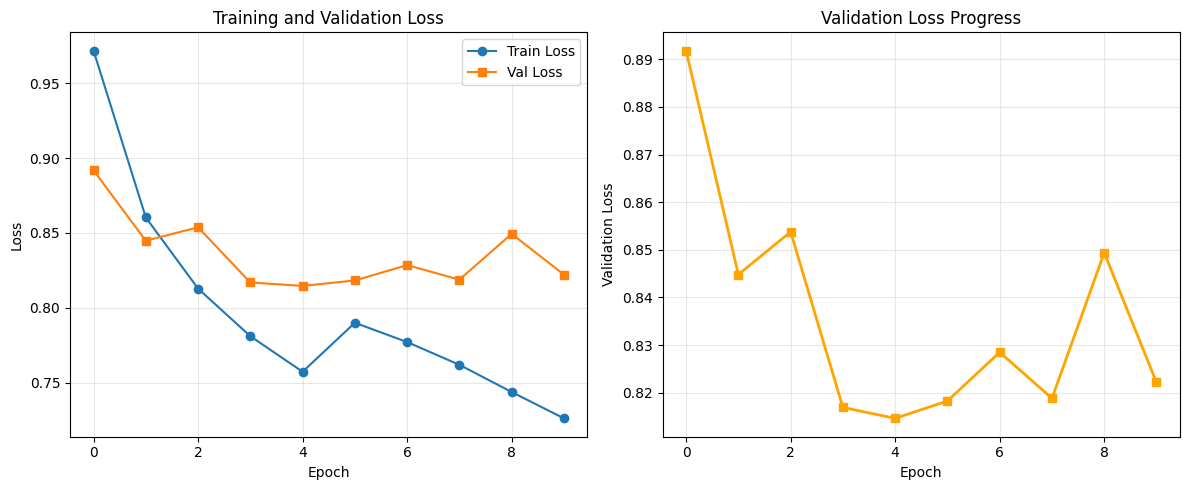

Training history saved to 'training_history.png'


In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history[0], label='Train Loss', marker='o')
plt.plot(history[1], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history[1], marker='s', color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Progress')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training history saved to 'training_history.png'")

In [16]:
def find_optimal_threshold(y_true, y_pred_proba, metric='f1'):
    """Find optimal threshold for binary classification"""
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_threshold = 0.5
    best_score = 0

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)

        if metric == 'f1':
            score = f1_score(y_true, y_pred, zero_division=0)
        elif metric == 'precision':
            score = precision_score(y_true, y_pred, zero_division=0)
        else:
            score = recall_score(y_true, y_pred, zero_division=0)

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_threshold, best_score

def evaluate_model_with_optimal_thresholds(model, data_loader, device, labels):
    """Evaluate model and find optimal thresholds for each class"""
    model.eval()
    all_labels = []
    all_preds = []

    print("Collecting predictions...")
    with torch.no_grad():
        for imgs, lbls in data_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs)

            all_labels.append(lbls.cpu().numpy())
            all_preds.append(probs.cpu().numpy())

    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    # Find optimal thresholds
    optimal_thresholds = {}
    results = []

    print("\nFinding optimal thresholds for each disease...")
    for i, label in enumerate(labels):
        y_true = all_labels[:, i]
        y_pred_proba = all_preds[:, i]

        # Find optimal threshold
        opt_thresh, best_f1 = find_optimal_threshold(y_true, y_pred_proba, metric='f1')
        optimal_thresholds[label] = opt_thresh

        # Calculate metrics with optimal threshold
        y_pred = (y_pred_proba >= opt_thresh).astype(int)

        # Handle ROC AUC
        if len(np.unique(y_true)) == 2:
            roc_auc = roc_auc_score(y_true, y_pred_proba)
        else:
            roc_auc = np.nan

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        results.append({
            'Label': label,
            'Threshold': opt_thresh,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc
        })

    metrics_df = pd.DataFrame(results)

    print(f"\n{'='*90}")
    print(f"{'EVALUATION RESULTS WITH OPTIMIZED THRESHOLDS':^90}")
    print(f"{'='*90}\n")
    print(metrics_df.round(4).to_string(index=False))

    # Calculate and print average metrics
    print(f"\n{'='*90}")
    print(f"{'AVERAGE METRICS':^90}")
    print(f"{'='*90}")
    print(f"  Average Accuracy:  {metrics_df['Accuracy'].mean():.4f}")
    print(f"  Average Precision: {metrics_df['Precision'].mean():.4f}")
    print(f"  Average Recall:    {metrics_df['Recall'].mean():.4f}")
    print(f"  Average F1-Score:  {metrics_df['F1-Score'].mean():.4f}")
    print(f"  Average ROC AUC:   {metrics_df['ROC AUC'].mean():.4f}")
    print(f"{'='*90}\n")

    return metrics_df, optimal_thresholds, all_labels, all_preds

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


In [17]:
# Load the best model (or SWA model for best results)
# Uncomment the one you want to use:

# Option 1: Best checkpoint model
model.load_state_dict(torch.load('best_chest_model.pth', map_location=device))
print("✓ Loaded: best_chest_model.pth")

# Option 2: SWA model (usually performs better)
# model.load_state_dict(torch.load('swa_chest_model.pth', map_location=device))
# print("✓ Loaded: swa_chest_model.pth")

model.eval()

# Evaluate
metrics_df, optimal_thresholds, true_labels, pred_probs = evaluate_model_with_optimal_thresholds(
    model, val_loader, device, LABELS
)

# Save results
metrics_df.to_csv('evaluation_metrics.csv', index=False)
print("✓ Metrics saved to 'evaluation_metrics.csv'")

✓ Loaded: best_chest_model.pth

Finding optimal thresholds for each disease...

                       EVALUATION RESULTS WITH OPTIMIZED THRESHOLDS                       

             Label  Threshold  Accuracy  Precision  Recall  F1-Score  ROC AUC
       Atelectasis       0.70    0.8348     0.3026  0.5152    0.3813   0.8060
      Cardiomegaly       0.85    0.9535     0.3040  0.5259    0.3853   0.9119
          Effusion       0.75    0.8608     0.4263  0.6275    0.5077   0.8732
      Infiltration       0.55    0.7106     0.3289  0.5535    0.4126   0.7023
              Mass       0.75    0.9241     0.2962  0.4228    0.3484   0.8314
            Nodule       0.75    0.9177     0.2864  0.2906    0.2885   0.7493
         Pneumonia       0.60    0.9362     0.0567  0.2607    0.0931   0.7613
      Pneumothorax       0.85    0.9345     0.3455  0.4838    0.4031   0.8781
     Consolidation       0.75    0.8721     0.1600  0.4700    0.2387   0.8085
             Edema       0.85    0.9455     0.17

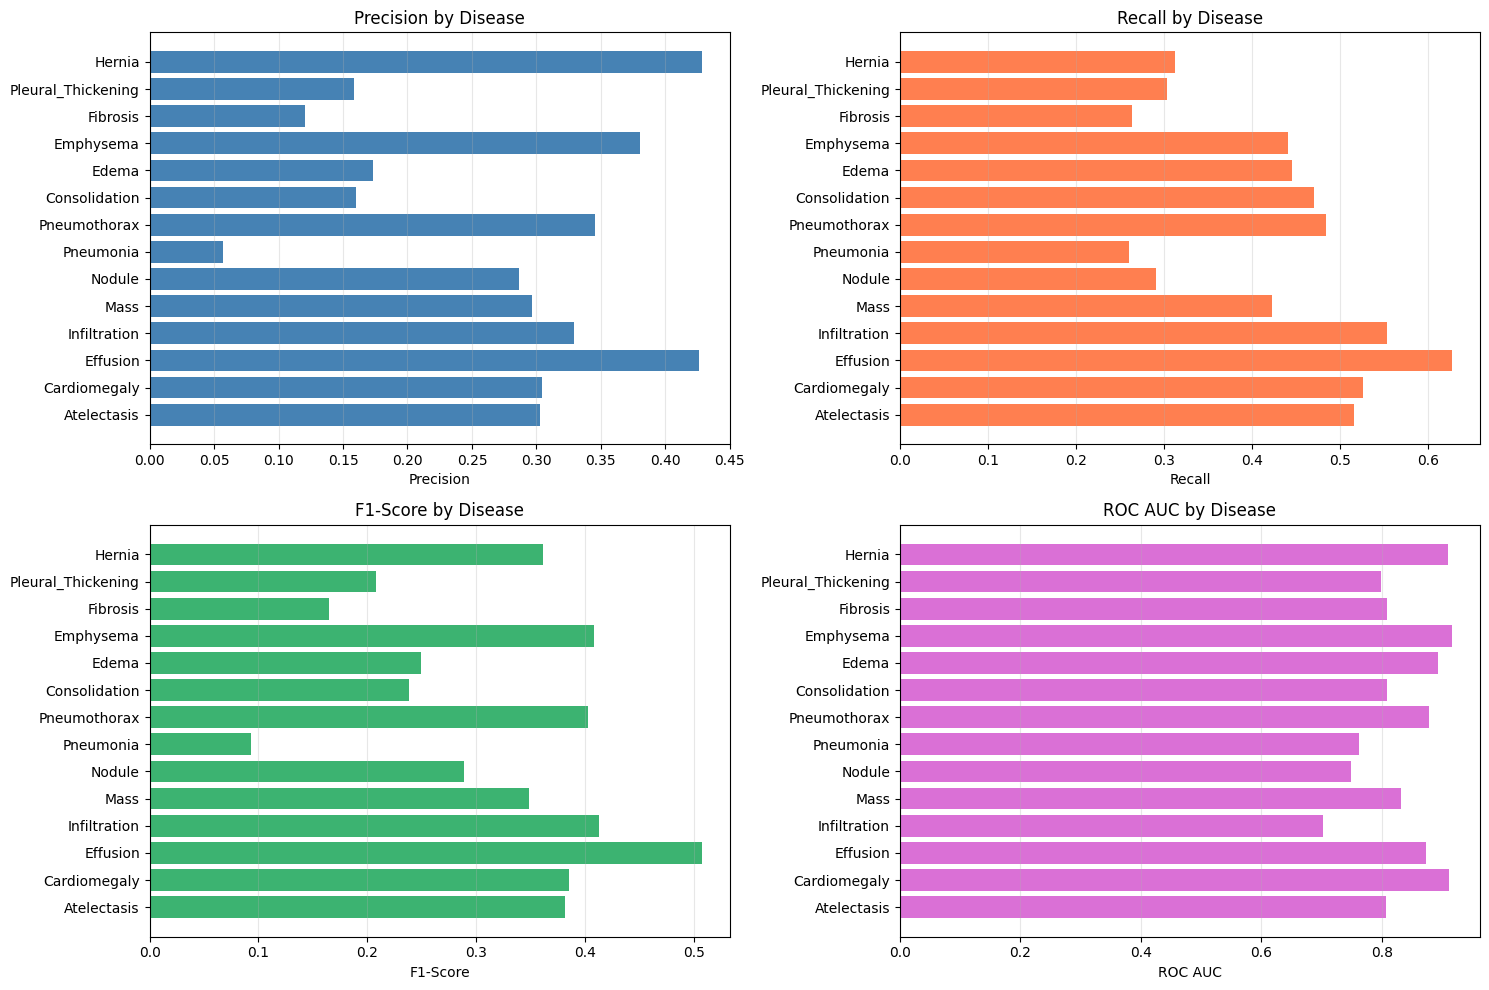

✓ Visualization saved to 'metrics_visualization.png'


In [18]:
# Plot metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Precision
axes[0, 0].barh(metrics_df['Label'], metrics_df['Precision'], color='steelblue')
axes[0, 0].set_xlabel('Precision')
axes[0, 0].set_title('Precision by Disease')
axes[0, 0].grid(axis='x', alpha=0.3)

# Recall
axes[0, 1].barh(metrics_df['Label'], metrics_df['Recall'], color='coral')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_title('Recall by Disease')
axes[0, 1].grid(axis='x', alpha=0.3)

# F1-Score
axes[1, 0].barh(metrics_df['Label'], metrics_df['F1-Score'], color='mediumseagreen')
axes[1, 0].set_xlabel('F1-Score')
axes[1, 0].set_title('F1-Score by Disease')
axes[1, 0].grid(axis='x', alpha=0.3)

# ROC AUC
axes[1, 1].barh(metrics_df['Label'], metrics_df['ROC AUC'], color='orchid')
axes[1, 1].set_xlabel('ROC AUC')
axes[1, 1].set_title('ROC AUC by Disease')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to 'metrics_visualization.png'")

In [19]:
def demo_predict(image_path, use_optimal_thresholds=True):
    """Predict diseases from a chest X-ray image"""
    model.eval()

    try:
        img = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"❌ Error: Image file '{image_path}' not found.")
        return
    except Exception as e:
        print(f"❌ Error loading image: {e}")
        return

    # Preprocess
    input_t = val_transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        logits = model(input_t)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    # Display image
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Chest X-Ray Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print results
    print(f"\n{'='*70}")
    print(f"{'PREDICTION RESULTS':^70}")
    print(f"{'='*70}\n")

    detected = False
    predictions = []

    for i, (label, prob) in enumerate(zip(LABELS, probs)):
        if use_optimal_thresholds:
            threshold = optimal_thresholds.get(label, 0.5)
        else:
            threshold = 0.5

        if prob > threshold:
            predictions.append((label, prob, threshold))
            detected = True

    if detected:
        predictions.sort(key=lambda x: x[1], reverse=True)
        print(f"{'Disease':<20} {'Probability':>15} {'Threshold':>15} {'Confidence':>15}")
        print(f"{'-'*70}")
        for label, prob, thresh in predictions:
            confidence = 'High' if prob > (thresh + 0.2) else 'Medium' if prob > (thresh + 0.1) else 'Low'
            print(f"{label:<20} {prob*100:>14.2f}% {thresh:>14.2f} {confidence:>15}")
    else:
        print("✓ No significant findings detected.")
        print("\nAll probabilities below their respective thresholds.")

    print(f"\n{'='*70}\n")

print("✓ Prediction function ready")


✓ Prediction function ready


Testing prediction on sample image...
Image: 00000007_000.png
Actual labels: No Finding



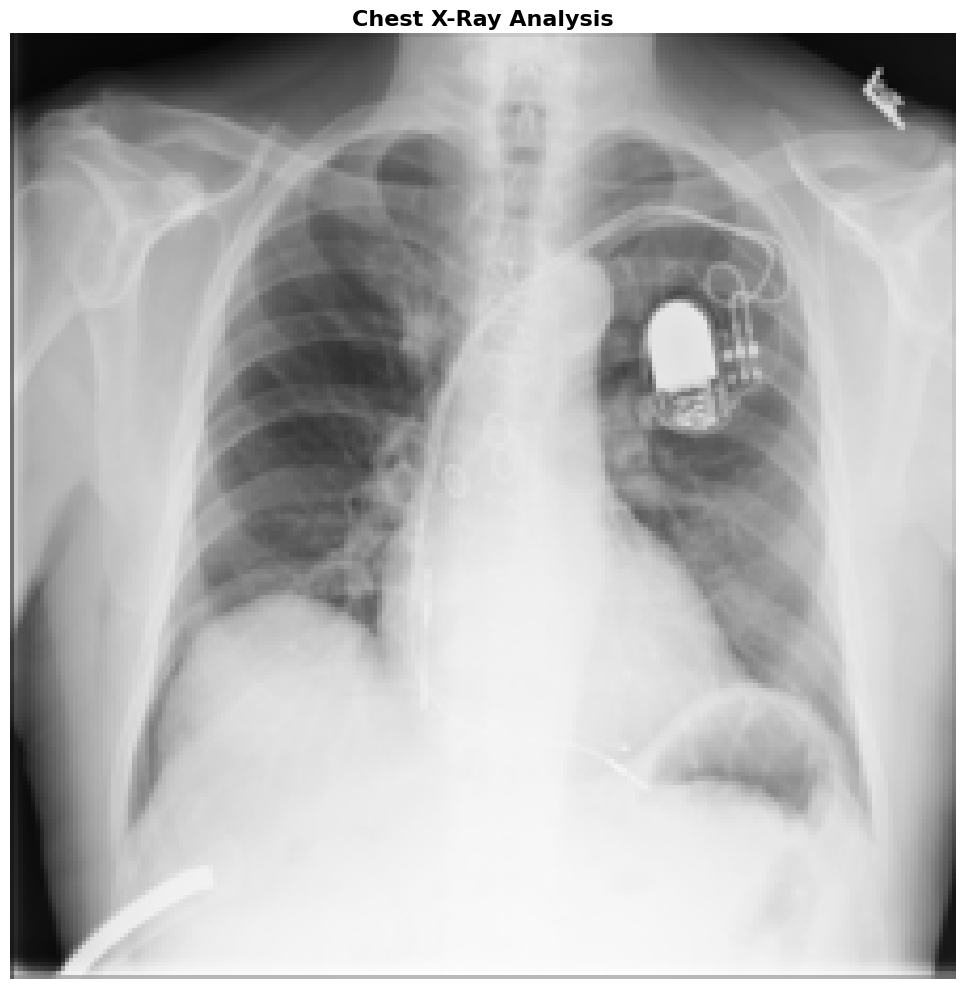


                          PREDICTION RESULTS                          

✓ No significant findings detected.

All probabilities below their respective thresholds.


✓ Batch prediction function ready


In [20]:
sample_image_path = os.path.join(IMAGE_DIR, val_df.iloc[0]['Image Index'])

print(f"Testing prediction on sample image...")
print(f"Image: {val_df.iloc[0]['Image Index']}")
print(f"Actual labels: {val_df.iloc[0]['Finding Labels']}\n")

demo_predict(sample_image_path, use_optimal_thresholds=True)

# ============================================================================
# CELL 17: Batch Prediction (Optional)
# ============================================================================

def batch_predict(image_paths, use_optimal_thresholds=True):
    """Predict diseases for multiple images"""
    model.eval()
    results = []

    for img_path in image_paths:
        try:
            img = Image.open(img_path).convert('RGB')
            input_t = val_transform(img).unsqueeze(0).to(device)

            with torch.no_grad():
                logits = model(input_t)
                probs = torch.sigmoid(logits).cpu().numpy()[0]

            predictions = {}
            for i, (label, prob) in enumerate(zip(LABELS, probs)):
                threshold = optimal_thresholds.get(label, 0.5) if use_optimal_thresholds else 0.5
                predictions[label] = {
                    'probability': float(prob),
                    'threshold': float(threshold),
                    'detected': bool(prob > threshold)
                }

            results.append({
                'image_path': img_path,
                'predictions': predictions
            })

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    return results

print("✓ Batch prediction function ready")


In [21]:
print(f"\n{'='*70}")
print(f"{'FINAL MODEL SUMMARY':^70}")
print(f"{'='*70}\n")

print("Model Details:")
print(f"  Architecture: EfficientNet-B4")
print(f"  Total Parameters: {total_params:,}")
print(f"  Training Epochs Completed: {len(history[0])}")
print(f"  Best Validation Loss: {min(history[1]):.4f}")

print(f"\nPerformance Metrics:")
print(f"  Average F1-Score:  {metrics_df['F1-Score'].mean():.4f}")
print(f"  Average Precision: {metrics_df['Precision'].mean():.4f}")
print(f"  Average Recall:    {metrics_df['Recall'].mean():.4f}")
print(f"  Average ROC AUC:   {metrics_df['ROC AUC'].mean():.4f}")



                         FINAL MODEL SUMMARY                          

Model Details:
  Architecture: EfficientNet-B4
  Total Parameters: 18,473,814
  Training Epochs Completed: 10
  Best Validation Loss: 0.8146

Performance Metrics:
  Average F1-Score:  0.3179
  Average Precision: 0.2691
  Average Recall:    0.4225
  Average ROC AUC:   0.8320
